# FiMDP basics

This notebook demostrates the basic tasks available in FiMDP. This includes creating Consumption MDPs (ConsMDPs), their visualization, simple qualitative analysis, and strategies. We provide more details in separate tutorials. We start with importing the package and calling `fimdp.setup()`, which configures FiMFP to create nicer visualizations.

In [1]:
import fimdp
fimdp.setup()

## Consmuption MDPs
Consumption MDPs are the model for which FiMDP was build. As an ordinary MDP, a ConsMDP has a set of states and a set of actions. An action can have a label and it's result is a distribution over possible outcomes (successor states). On top of regular MDPs, ConsMDPs work with a contraint amount of _resource_, which is _consumed_ by actions and reloaded into full capacity in _reload states_. The consumption of actions is a integral part of the definition of actions as we shall see in the following example. States in FiMDP are represented as integers indexed from 0. Actions are represented by objects of the `ActionData` class.

### How to create ConsMDPs

In [2]:
mdp = fimdp.ConsMDP()
# Create 5 states and define names for them
mdp.new_states(5, names=["r", "s", "u", "v", "t"])
# We have two reload states: r and t
mdp.set_reload([0, 4])

# Define actions (src stands for source, the origin state of the action)
# Distribution is a dictionary of the type "outcome → probability"
# where the sum over probabilities should be 1
mdp.add_action(src=1, distribution={3:.1, 0:.9}, label="β", consumption=1)
mdp.add_action(src=0, distribution={1:1}, label="α", consumption=1)
mdp.add_action(1, {2:1}, "α", 1)
mdp.add_action(2, {4:1}, "α", 1)
mdp.add_action(3, {4:1}, "α", 0)
mdp.add_action(4, {4:1}, "α", 1);

### Viusalization of Consumption MDPs

In Jupyter notebooks, ConsMDPs are automaticallyt visualized if they are returned as the last result in a cell. The black solid labels are of the form `label: consumption`, and the gray edges are labeled by the `probability` of the corresponding outcome.

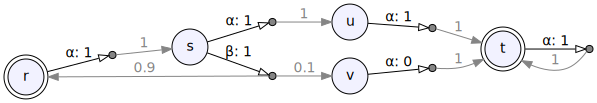

In [3]:
mdp

We can also use the function `mdp.show()`, which accepts some additional options. For example, we can highlight some states of interests by green color by setting them as _target_ states.

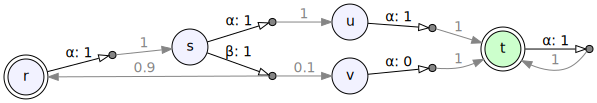

In [4]:
mdp.show(targets=[4])

For large ConsMDPs, it might be convenient to show just a part of it. Currently, at most 50 states are shown by default (big images can stuck the kernel). We can also change this using `max_states` argument. 

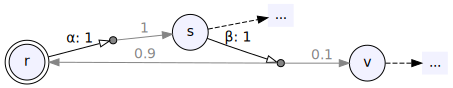

In [5]:
mdp.show(max_states=3, targets=[4])

## Qualitative Analysis of ConsMPDs

FiMDP is tool that performs qualitative analysis. This means that we detect, from which state and which level of resource, a given _objective_ is satisfied with probability 1 (or >0). 

### Objectives
FiMDP currently implements algorithms for solving 4 basic objectives:
 * Survival (aka safety)
 * Positive reachability
 * Reachability (aka almost-sure reachability)
 * Büchi (visit target states infinitely often)
 
The difference between positive and almost-sure reachability is in the probability threshold of interest. The positive reachability is satisfied, if probability of reaching some target state is greate than 0. Almost-sure reachability is satisfied if the probability of reaching some target state is equal to 1. In both cases, the reachability part interprets as "reach the green states and survive afterwards".

On top of that, FiMDP also solves the _minimal initial consumption_ problem. Loosely speaking, given a state $s$. the minimal initial consumption of $s$ is the minimal amount of energy needed to reach some reload state. Note that this does not automatically guarantee survival. The minimal initial consumption is the base for most of the implemented algorithms.

To specify an objective, we use the constants defined in module `fimpd.objectives`.

### Solvers
Solvers are the objects that perform the analysis. FiMDP contains solvers that take the reload states and consumption into account, we call them _energy solvers_. They are implemented in the `fimdp.energy_solvers` module. An energy solver needs the ConsMDP, some capacity, and set of targets (can be an empty list) as input.

We illustrate the different objectives and how solvers work on a larger example. We use on of the examples provided in FiMDP directly. We will use the BasicES (stands for basic energy solver) solver. To see other energy solvers and more details about solvers in general, see the [Solvers notebook](Solvers.ipynb).

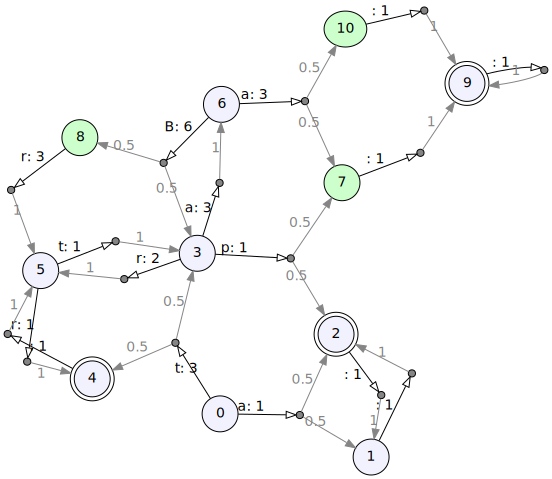

In [6]:
from fimdp.examples.cons_mdp import ultimate
mdp, T = ultimate()
mdp.show(targets=T)

We will use the BasicES (stands for basic energy solver) solver. Each energy solver provides 3 functions, each requires an objective. We first call `solver.compute` on all relevant objectives. This actually computes both the minimal levels of energy needed to satisfy the given objective and corresponding action selectors (similar to strategies).

In [7]:
solver = fimdp.energy_solvers.BasicES(mdp, cap=15, targets=T)
solver.compute(fimdp.objectives.SAFE)
solver.compute(fimdp.objectives.POS_REACH)
solver.compute(fimdp.objectives.AS_REACH)
solver.compute(fimdp.objectives.BUCHI)

For each state and objective, the solver just computed the minimal level of resource needed from that state to satisfy the given objective. We can see them using `solver.get_min_levels` function. This function returns the values if they are already computed, and compute them first otherwise.

In [8]:
solver.get_min_levels(fimdp.objectives.SAFE)

[2, 1, 0, 2, 0, 1, 4, 1, 4, 0, 1]

For small ConsMDPs, we can also show these values visually. For survival, the following command does that. You can see that the little red numbers are the same as printed above.

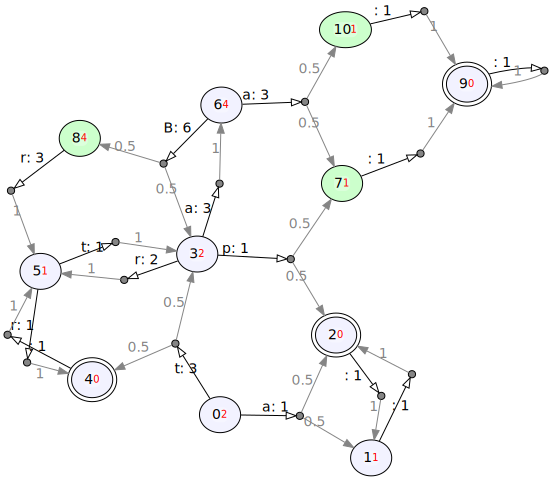

In [9]:
solver.show("s")

In fact, the visual representation can show all the objectives already computed by the solver, at the same time. And it does so by default. The `".l"` option shows also a legend that helps to match the values to objectives. If a state $s$ has ∞ for given objective, that means that no initial amount is sufficient to satisfy the objective from that state with the specified capacity.

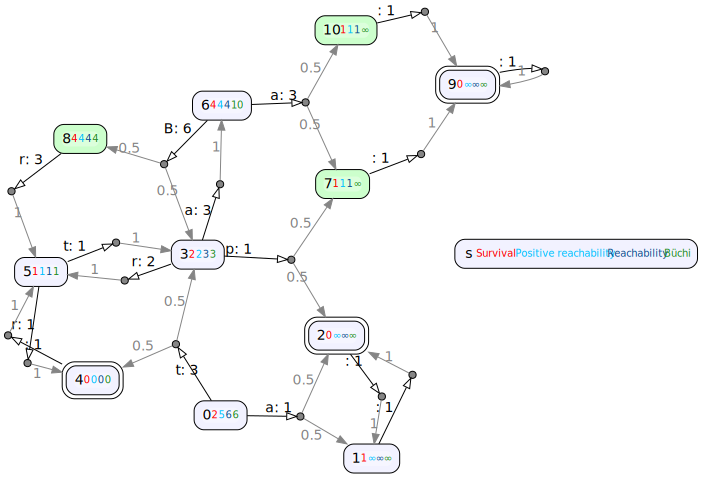

In [10]:
solver.show(".l")

In the example above, we can analyze how positive reachability and (almost-sure) reachability differ: In state 0, we need at least 6 units of resource to reach the green states almost-surely (via the reload state 4), while 5 is enough to reach the green states with a probability greater than 0 (actions `t`, `p` can result in 7). Similarly, we can reach the green states surely from 6 with just 4 units of energy (action `a` surely results in a green state, and 1 unit of resource is enough from these states to survive), while we need to have at least 10 for visiting them infinitely often (the state 8 with reloading in 4).

If we want to check how the levels changes with a different capacity, we need to create a new solver object. For example, we can verify that 15 was indeed a minimal capacity needed to satisfy Büchi from state 6. The capacity of 14 units is not enough.

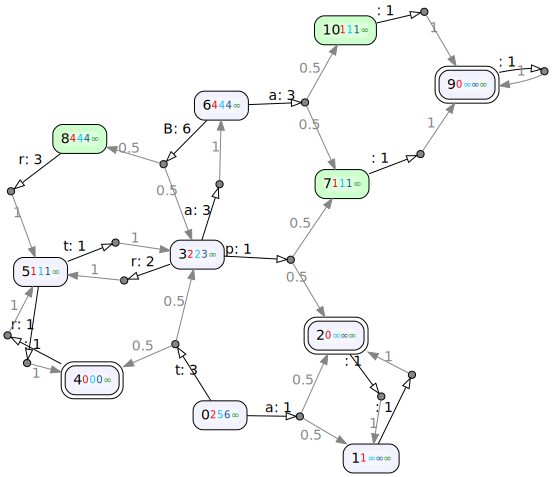

In [11]:
solver2 = fimdp.energy_solvers.BasicES(mdp, 14, T)
solver2.get_min_levels(fimdp.objectives.SAFE)
solver2.get_min_levels(fimdp.objectives.POS_REACH)
solver2.get_min_levels(fimdp.objectives.AS_REACH)
solver2.get_min_levels(fimdp.objectives.BUCHI)
solver2

## Strategies and Simulations
You can find more details about strategies, selectors and simulators in [Strategies.ipynb](Strategies.ipynb).

We also investigate the strategies computed by the solver and verify, that the computed values are indeed sufficient. In general, a strategy for given MDP decides what action to play based on (possibly), the whole history (of states and actions seen and played so far. To abstract from the whole histories, simple strategies remember only the relevant information. For example, the last state in memoryless strategies. In ConsMDP, memoryless strategies would not be successful. In order to survive in a ConsMDP, the strategy needs to track the resource level along the play. We use _counter strategies_ which use a counter to track the resource level in combination with an _action selector_ that makes the decision, what action to play given the current level of resource and the current state. Action selectors are the key ingredient of counter strategies and they are the objects computed by our solvers.

In [12]:
selector = solver.get_selector(fimdp.objectives.BUCHI)
selector

[{6: 0——t[3]——>{3: 0.5, 4: 0.5}},
 {},
 {},
 {13: 3——a[3]——>{6: 1}, 3: 3——r[2]——>{5: 1}},
 {0: 4——[1]——>{5: 1}},
 {14: 5——t[1]——>{3: 1}, 1: 5——r[1]——>{4: 1}},
 {10: 6——B[6]——>{3: 0.5, 8: 0.5}},
 {},
 {4: 8——r[3]——>{5: 1}},
 {},
 {}]

In the example above, the selector is represented as a list (for each state) of _selection rules_ (fancy dictionaries). A selection rule for given state tells us, what action to play in winning intervals of resource levels. Let's see an example for state 3. We have 2 intervals. For energy between 3 and 12, we should play the action `r` (go-to-reload), and the action `a` (go-to-target) for energy 13 and more.

In [13]:
print(selector[3])

{
  3 — 12: r,
  13+: a
}


We can also ask the selector directly, what action should be played in state 5 with energy 8. It is the action `r` that goes from `5` always (prob=1) to state 4 with consumption 1.

In [14]:
selector.select_action(state=5, energy=8)

5——r[1]——>{4: 1}

Having an action selector, we can create a `CounterStrategy` object and play with that. Let's start a play in state 6 with energy 10.

In [15]:
strategy = fimdp.core.CounterStrategy(mdp, selector, capacity=solver.cap, 
                                      init_energy=10, init_state=6)

Using `strategy.next_action`, we ask the strategy what action to play.

In [16]:
strategy.next_action()

6——B[6]——>{3: 0.5, 8: 0.5}

The action `B` has two possible outcomes: 3 and 8. We can resolve this to 3 and 8. Let's say that the action was resolved to 3. We communicate that to the strategy using `strategy.update_state(3)`. Then we can ask for the next action again.

In [17]:
strategy.update_state(3)
strategy.next_action()

3——r[2]——>{5: 1}

We can also create a simulator and ask it to resolve the outcomes for us and to create us a sample plays.

In [18]:
strategy = fimdp.core.CounterStrategy(mdp, selector, capacity=solver.cap, 
                                      init_energy=10, init_state=6)
sim = fimdp.core.Simulator(strategy, num_steps=50)

The history is stored in `sim.state_history` and `sim.action_history` lists.

In [19]:
print(sim.state_history)

[6, 8, 5, 4, 5, 3, 6, 8, 5, 4, 5, 3, 6, 3, 5, 4, 5, 3, 6, 8, 5, 4, 5, 3, 6, 3, 5, 4, 5, 3, 6, 3, 5, 4, 5, 3, 6, 8, 5, 4, 5, 3, 6, 3, 5, 4, 5, 3, 6, 8, 5]


In [22]:
for action in sim.action_history:
    print(action)

6——B[6]——>{3: 0.5, 8: 0.5}
8——r[3]——>{5: 1}
5——r[1]——>{4: 1}
4——[1]——>{5: 1}
5——t[1]——>{3: 1}
3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}
8——r[3]——>{5: 1}
5——r[1]——>{4: 1}
4——[1]——>{5: 1}
5——t[1]——>{3: 1}
3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}
3——r[2]——>{5: 1}
5——r[1]——>{4: 1}
4——[1]——>{5: 1}
5——t[1]——>{3: 1}
3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}
8——r[3]——>{5: 1}
5——r[1]——>{4: 1}
4——[1]——>{5: 1}
5——t[1]——>{3: 1}
3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}
3——r[2]——>{5: 1}
5——r[1]——>{4: 1}
4——[1]——>{5: 1}
5——t[1]——>{3: 1}
3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}
3——r[2]——>{5: 1}
5——r[1]——>{4: 1}
4——[1]——>{5: 1}
5——t[1]——>{3: 1}
3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}
8——r[3]——>{5: 1}
5——r[1]——>{4: 1}
4——[1]——>{5: 1}
5——t[1]——>{3: 1}
3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}
3——r[2]——>{5: 1}
5——r[1]——>{4: 1}
4——[1]——>{5: 1}
5——t[1]——>{3: 1}
3——a[3]——>{6: 1}
6——B[6]——>{3: 0.5, 8: 0.5}
8——r[3]——>{5: 1}
